## Importando Paqueteria

In [2]:
!pip install scalecast

In [3]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.ERROR)

# Visualizando la serie

In [5]:
index = pd.read_csv("HighYield.csv")
index.columns = ['Date', 'yield']
index.head()

,Date,yield
0,2020-04-09,8.42
1,2020-04-10,NaN
2,2020-04-13,8.19
3,2020-04-14,7.83
4,2020-04-15,8.03


In [6]:
print(index['Date'].dtype)

object


In [7]:
index['Date'] = pd.to_datetime(index['Date'], errors='coerce')
print(index['Date'].dtype)

datetime64[ns]


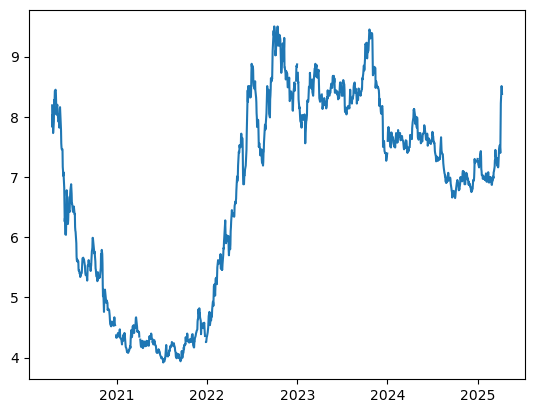

In [8]:
plt.plot(index["Date"], index["yield"])
plt.show()

In [9]:
if 'Date' in index.columns and index['Date'].dtype == 'object':
    index['Date'] = pd.to_datetime(index['Date'], errors='coerce')
    print("Columna 'Date' convertida a datetime.")
elif 'Date' in index.columns and index['Date'].dtype == '<M8[ns]':
    print("La columna 'Date' ya está en formato datetime.")
else:
    print("No se encontró la columna 'Date' o no tiene el tipo esperado.")

La columna 'Date' ya está en formato datetime.


In [10]:
if 'Date' in index.columns:
    index = index.set_index('Date', drop=True)
    print("Columna 'Date' establecida como índice.")
else:
    print("No se puede establecer 'Date' como índice porque no existe la columna.")

Columna 'Date' establecida como índice.


In [11]:
print(f"Tipo de índice después de set_index: {type(index.index)}")
print(f"Tipo de dato del índice: {index.index.dtype}")

Tipo de índice después de set_index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Tipo de dato del índice: datetime64[ns]


In [12]:
if isinstance(index.index, pd.DatetimeIndex):
    try:
        index = index.asfreq('D')
        print("Frecuencia establecida a: Diario ('D').")
    except ValueError as e:
        print(f"No se pudo establecer la frecuencia diaria: {e}")
        print("Asegúrate de que tu índice de fechas sea válido y esté ordenado.")
elif index.index.dtype == 'int64':
    print("El índice es de tipo int64. Asegúrate de haber establecido la columna de fechas como índice antes de intentar establecer la frecuencia.")
else:
    print("El índice no es DatetimeIndex. No se puede establecer la frecuencia diaria.")

Frecuencia establecida a: Diario ('D').


In [13]:
Index = Forecaster(
    y=index['yield'],
    current_dates=index.index,
    future_dates = 12,
    test_length = .2,
    cis = True,
)
Index

Forecaster(
    DateStartActuals=2021-09-11T00:00:00.000000000
    DateEndActuals=2025-04-09T00:00:00.000000000
    Freq=D
    N_actuals=1307
    ForecastLength=12
    Xvars=[]
    TestLength=365
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [14]:
Index.set_estimator('arima')
Index.manual_forecast(call_me='arima1')

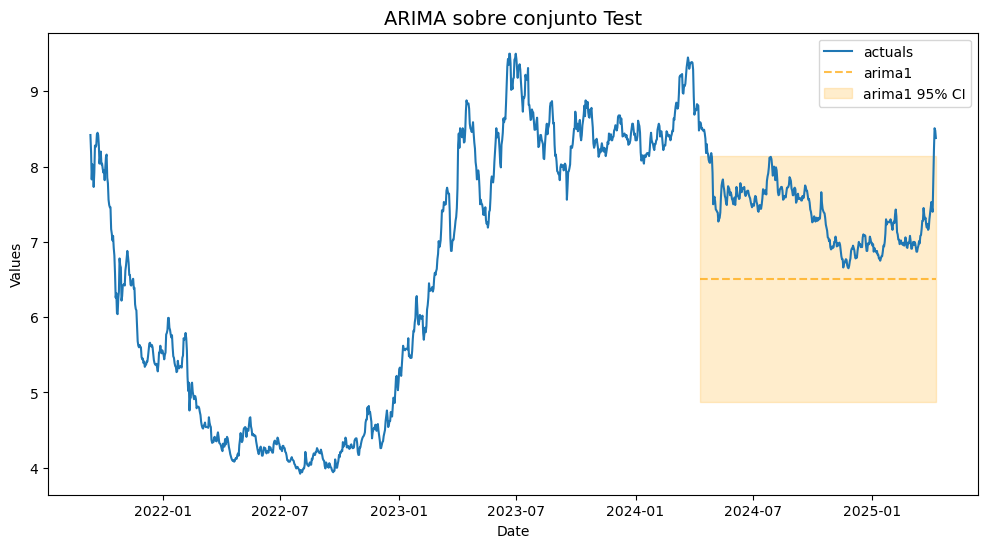

In [15]:
Index.plot_test_set(ci=True)
plt.title('ARIMA sobre conjunto Test',size=14)
plt.show()

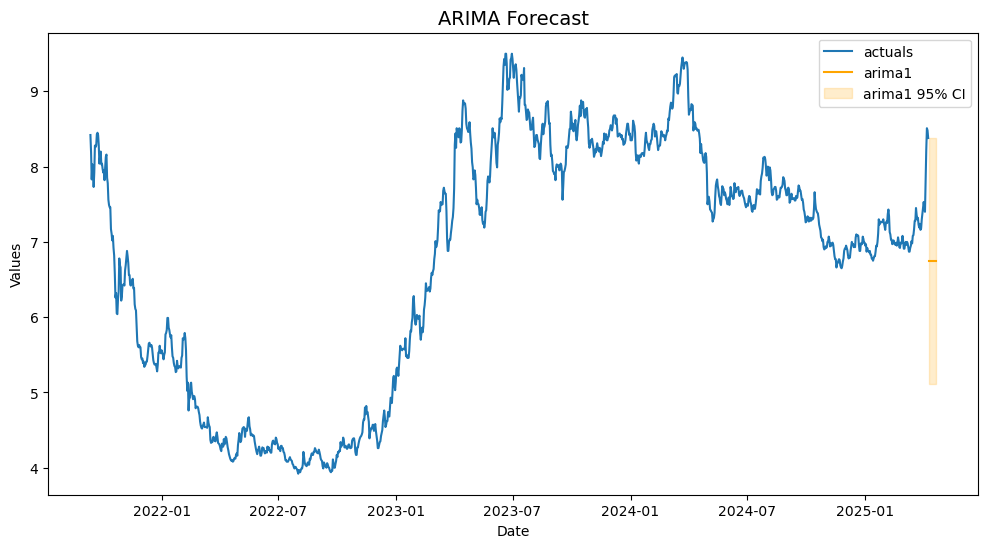

In [16]:
Index.plot(ci=True)
plt.title('ARIMA Forecast',size=14)
plt.show()

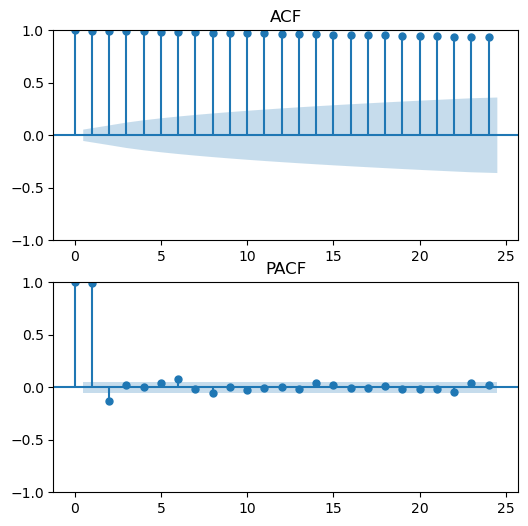

In [17]:
figs, axs = plt.subplots(2, 1,figsize=(6,6))
Index.plot_acf(ax=axs[0],title='ACF',lags=24)
Index.plot_pacf(ax=axs[1],title='PACF',lags=24)
plt.show()

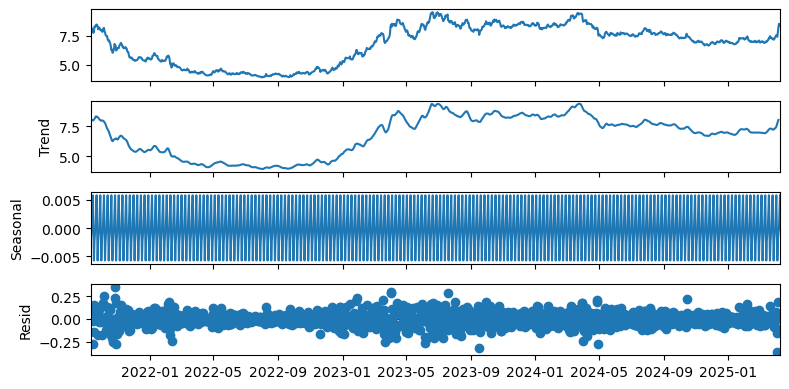

In [18]:
plt.rc("figure",figsize=(8,4))
Index.seasonal_decompose().plot()
plt.show()

In [19]:
#Test ADF
stat, pval, _, _, _, _ = Index.adf_test(full_res=True)
print(stat)
print(pval)
print(Index.adf_test)

-1.24472140770747
0.6540680983658568
<bound method Forecaster.adf_test of Forecaster(
    DateStartActuals=2021-09-11T00:00:00.000000000
    DateEndActuals=2025-04-09T00:00:00.000000000
    Freq=D
    N_actuals=1307
    ForecastLength=12
    Xvars=[]
    TestLength=365
    ValidationMetric=rmse
    ForecastsEvaluated=['arima1']
    CILevel=0.95
    CurrentEstimator=arima
    GridsFile=Grids
)>


In [20]:
!pip install pmdarima

In [21]:
auto_arima(
    Index,
    m=12,
    call_me='arima2',
)

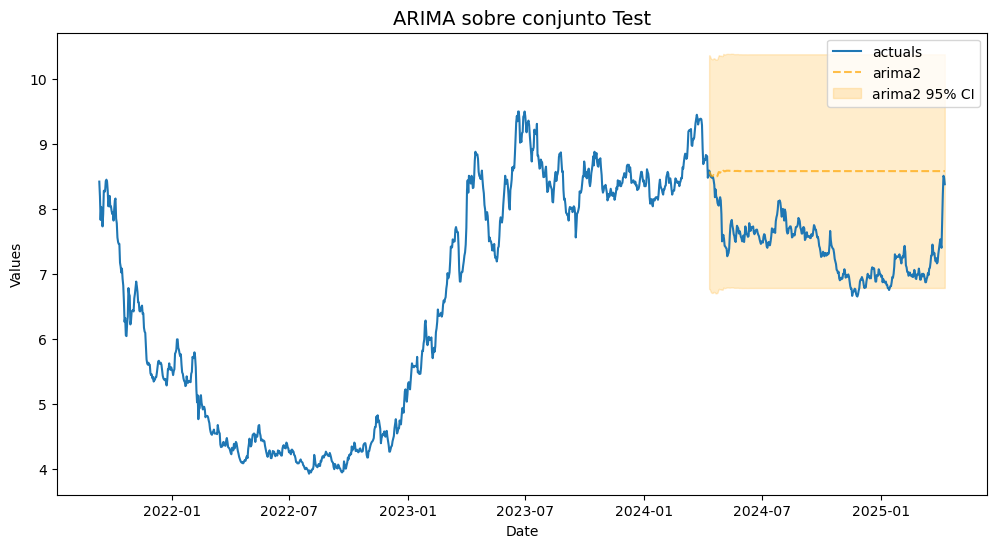

In [22]:
Index.plot_test_set(ci=True,models='arima2')
plt.title('ARIMA sobre conjunto Test',size=14)
plt.show()

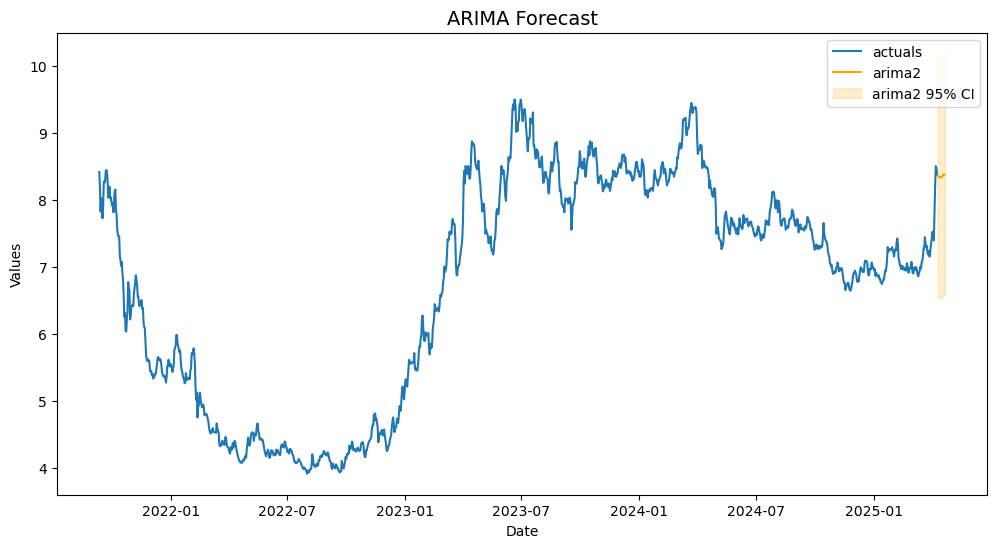

In [23]:
Index.plot(ci=True,models='arima2')
plt.title('ARIMA Forecast',size=14)
plt.show()

In [24]:
print(Index.regr.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                 1307
Model:             ARIMA(1, 1, 0)x(2, 0, 0, 12)   Log Likelihood                1254.959
Date:                          Sat, 12 Apr 2025   AIC                          -2501.918
Time:                                  02:29:44   BIC                          -2481.219
Sample:                                       0   HQIC                         -2494.153
                                         - 1307                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2128      0.019     11.439      0.000       0.176       0.249
ar.S.L12       0.0289      0.022      1.321      0.

In [25]:
Index.set_validation_length(12)
grid = {
    'order':[
        (1,1,1),
        (1,1,0),
        (0,1,1),
    ],
    'seasonal_order':[
        (2,1,1,12),
        (1,1,1,12),
        (2,1,0,12),
        (0,1,0,12),
    ],
}

Index.ingest_grid(grid)
Index.tune()
Index.auto_forecast(call_me='arima3')

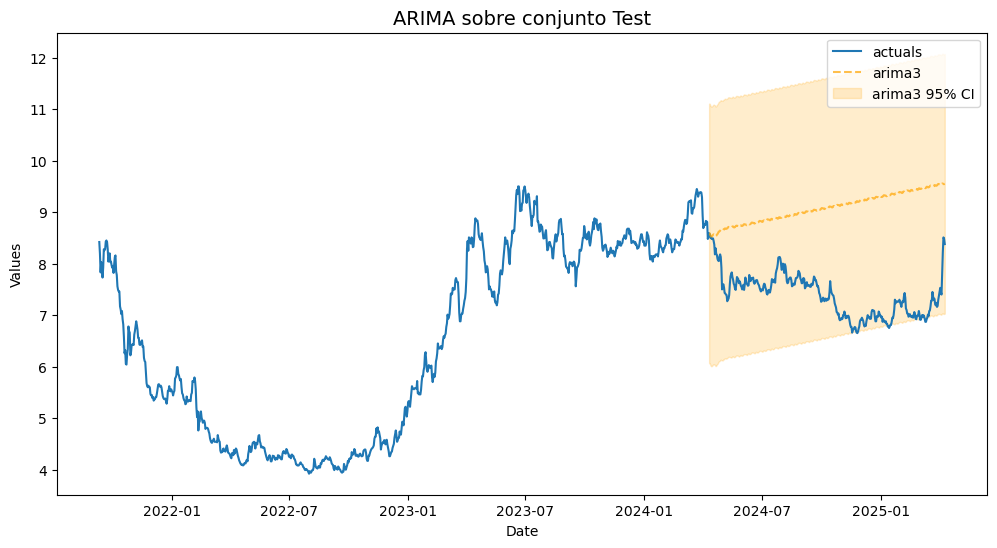

In [26]:
Index.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA sobre conjunto Test',size=14)
plt.show()

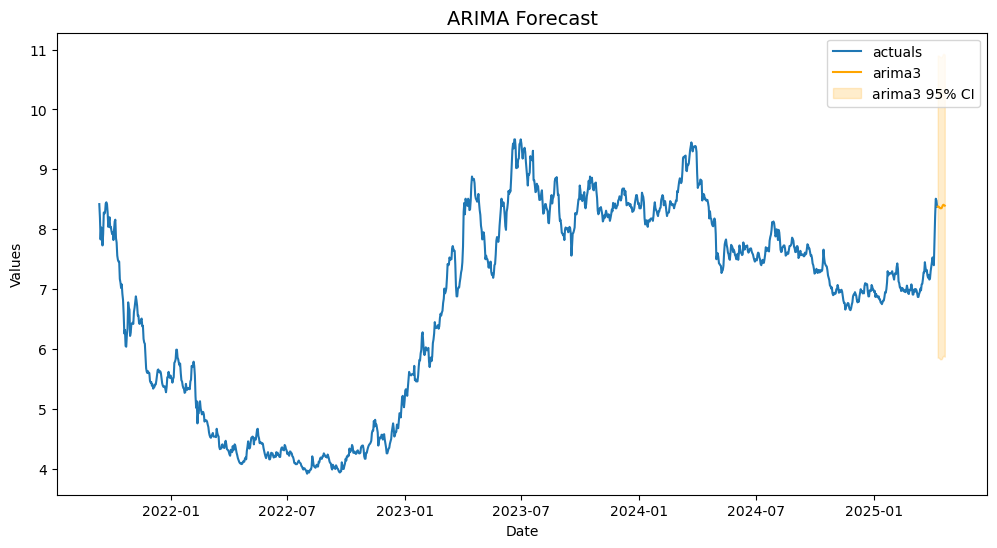

In [27]:
Index.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast',size=14)
plt.show()

In [28]:
print(Index.regr.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1307
Model:             ARIMA(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood                1215.700
Date:                            Sat, 12 Apr 2025   AIC                          -2421.400
Time:                                    02:31:05   BIC                          -2395.572
Sample:                                         0   HQIC                         -2411.707
                                           - 1307                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2132      0.019     10.934      0.000       0.175       0.251
ar.S.L12       0.0251      0.023   

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=-2492.486, Time=3.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2435.677, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2493.467, Time=0.75 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2491.670, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2437.677, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-2494.520, Time=0.25 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-2493.655, Time=0.82 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-2496.347, Time=2.25 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-2498.351, Time=3.09 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-2499.920, Time=1.98 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-2441.905, Time=1.54 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-2497.956, Time=2.44 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-2497.950, Time=2.14 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=-2497.878, Time=1.60 sec
 ARIM

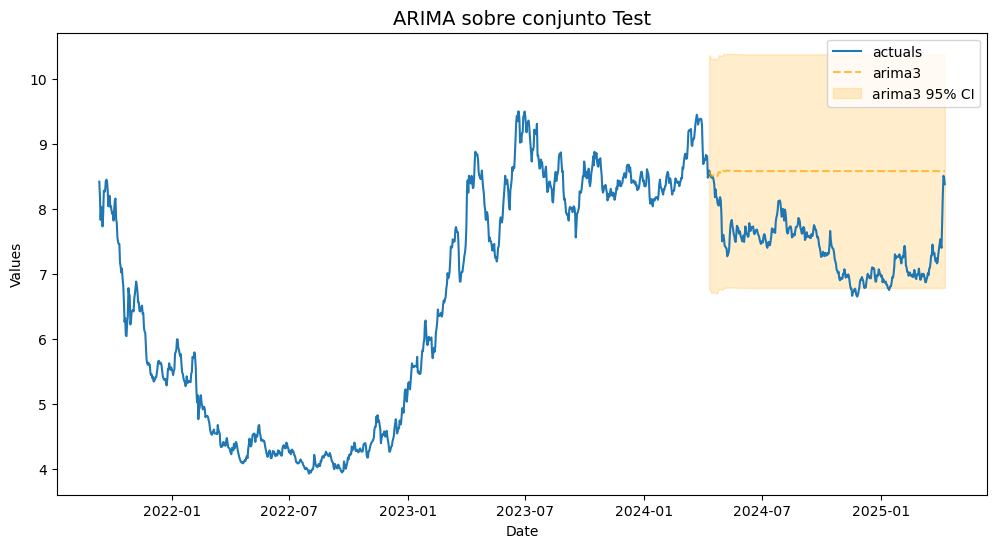

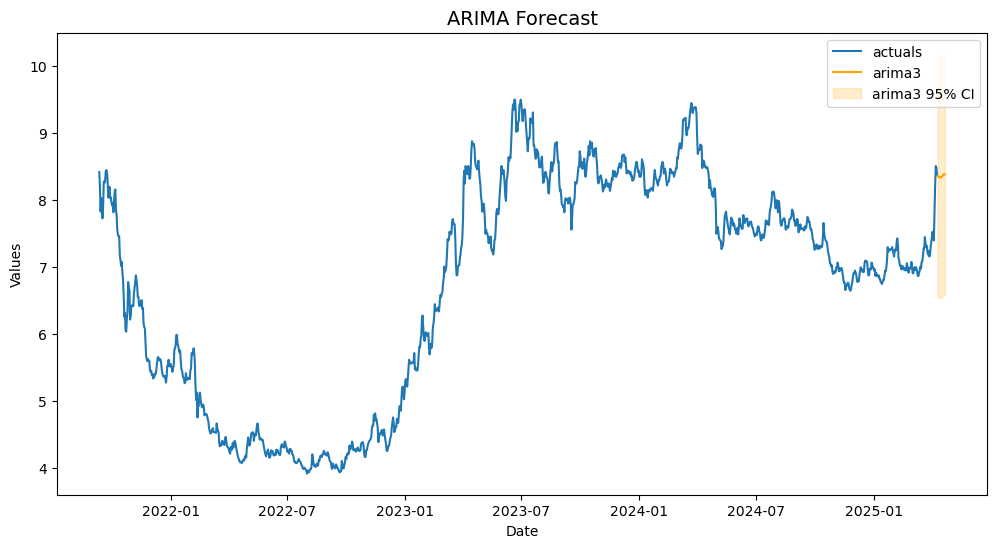

In [29]:
auto_arima(
    Index,
    start_P=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=12,
    seasonal=True,
    max_P=2,
    max_D=2,
    max_Q=2,
    max_d=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='arima3',
)

Index.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA sobre conjunto Test',size=14)
plt.show()

Index.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast',size=14)
plt.show()

In [30]:
print(Index.regr.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                 1307
Model:             ARIMA(1, 1, 0)x(2, 0, 0, 12)   Log Likelihood                1254.959
Date:                          Sat, 12 Apr 2025   AIC                          -2501.918
Time:                                  02:31:48   BIC                          -2481.219
Sample:                                       0   HQIC                         -2494.153
                                         - 1307                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2128      0.019     11.439      0.000       0.176       0.249
ar.S.L12       0.0289      0.022      1.321      0.

## Procesos GARCH para volatilidad


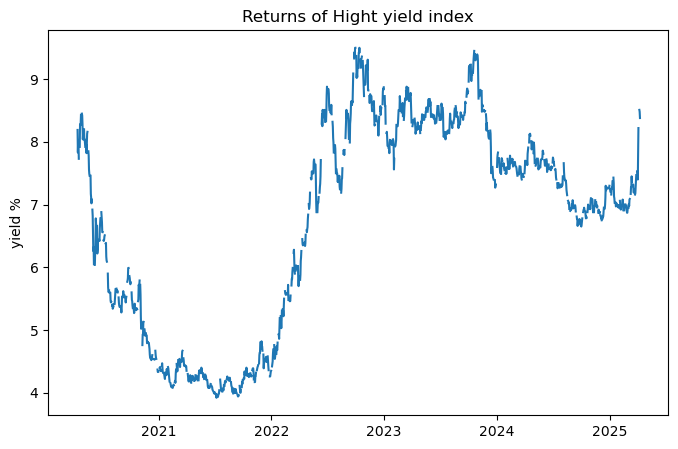

In [32]:
plt.figure(figsize=(8,5))
plt.plot(index['yield'])
plt.ylabel("yield %")
plt.title('Returns of Hight yield index');

In [33]:
!pip install arch

In [34]:
index['returns'] = index['yield'].pct_change()
index.dropna(subset=['returns'], inplace=True)
abs_returns = np.abs(index['returns'])

In [35]:
# Fit GARCH (1,1)
from arch import arch_model
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(abs_returns, train_size= 0.8)

garch_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch = garch_mod.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4197.377249694484
Iteration:      2,   Func. Count:     11,   Neg. LLF: -3398.1766929913465
Iteration:      3,   Func. Count:     19,   Neg. LLF: 936681108.2321539
Iteration:      4,   Func. Count:     26,   Neg. LLF: -3544.8910449502273
Iteration:      5,   Func. Count:     33,   Neg. LLF: -4421.142863348592
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4421.142863657929
            Iterations: 9
            Function evaluations: 33
            Gradient evaluations: 5


In [80]:
forecast_horizon = 12
forecast_result = res_garch.forecast(horizon=forecast_horizon)
variance_forecasts = forecast_result.variance.iloc[-1]
volatility_forecasts = np.sqrt(variance_forecasts)
print(f"GARCH Volatility Forecast for the next {forecast_horizon} periods:")
print(volatility_forecasts)

GARCH Volatility Forecast for the next 12 periods:
h.01    0.011641
h.02    0.011657
h.03    0.011671
h.04    0.011684
h.05    0.011696
h.06    0.011706
h.07    0.011716
h.08    0.011724
h.09    0.011732
h.10    0.011739
h.11    0.011745
h.12    0.011751
Name: 2020-07-08 00:00:00, dtype: float64


In [37]:
# Model summary 
print(res_garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                4421.14
Distribution:                  Normal   AIC:                          -8836.29
Method:            Maximum Likelihood   BIC:                          -8820.43
                                        No. Observations:                 1460
Date:                Sat, Apr 12 2025   Df Residuals:                     1460
Time:                        02:31:58   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.3445e-05  4.532e-11  2.967e+05      0.000 

## Forecast Volatility)

In [78]:
# Forecast the test set 
yhat = res_garch.forecast(horizon = y_test.shape[0], reindex=True)
yhat

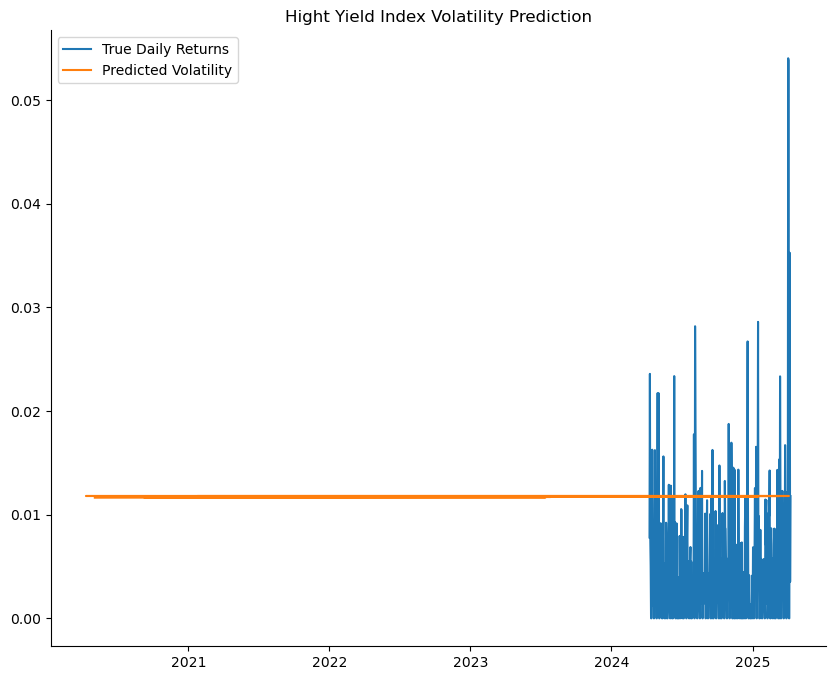

In [40]:
fig,ax = plt.subplots(figsize=(10,8))
ax.spines[['top','right']].set_visible(False)
# Plot test set returns
plt.plot(abs_returns[-y_test.shape[0]:])
# Plot volatility estimates for test set
plt.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
plt.title('Hight Yield Index Volatility Prediction')
plt.legend(['True Daily Returns', 'Predicted Volatility'])